In [97]:
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import numpy as np

scores = []
n_tps = []

y_true = np.zeros(50000)

y_true[:100] = 1

for i in range(20):
    n_tp = i*5

    y_pred = np.zeros(50000)
    y_pred[:n_tp] = 1

    n_tps.append(n_tp)
    scores.append(fbeta_score(y_true, y_pred, beta = 0.5))

Text(0.5, 1.0, '100 positive labels, no false positives')

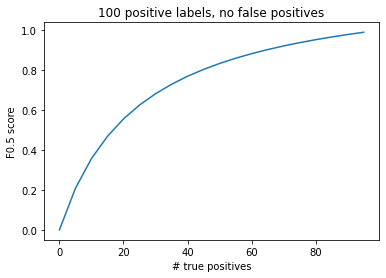

In [101]:
plt.plot(n_tps, scores)
plt.xlabel('# true positives')
plt.ylabel('F0.5 score')
plt.title('100 positive labels, no false positives')

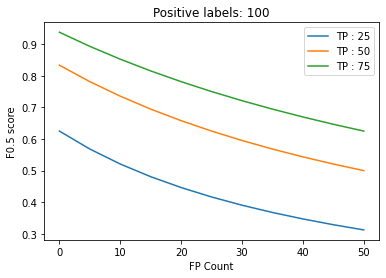

In [109]:
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import numpy as np

scores = []
n_fps = []
y_true = np.zeros(50000)
y_true[:100] = 1

for i in range(11):
    n_tp = 25
    n_fp = 5*i

    y_pred = np.zeros(50000)
    y_pred[:n_tp] = 1
    y_pred[100:100+n_fp] = 1

    n_fps.append(n_fp)
    scores.append(fbeta_score(y_true, y_pred, beta = 0.5))

plt.plot(n_fps, scores)

scores = []
n_fps = []
y_true = np.zeros(50000)
y_true[:100] = 1

for i in range(11):
    n_tp = 50
    n_fp = 5*i

    y_pred = np.zeros(50000)
    y_pred[:n_tp] = 1
    y_pred[100:100+n_fp] = 1

    n_fps.append(n_fp)
    scores.append(fbeta_score(y_true, y_pred, beta = 0.5))

plt.plot(n_fps, scores)

scores = []
n_fps = []
y_true = np.zeros(50000)
y_true[:100] = 1

for i in range(11):
    n_tp = 75
    n_fp = 5*i

    y_pred = np.zeros(50000)
    y_pred[:n_tp] = 1
    y_pred[100:100+n_fp] = 1

    n_fps.append(n_fp)
    scores.append(fbeta_score(y_true, y_pred, beta = 0.5))

plt.plot(n_fps, scores)

plt.title('Positive labels: 100')
plt.xlabel('FP Count')
plt.ylabel('F0.5 score')
plt.legend([f'TP : {i}' for i in [25, 50, 75]])

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
import nltk
import random
from nltk.tokenize import word_tokenize,sent_tokenize
import pickle

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
docIdx = train_example_names.copy()

In [2]:
from bert_sklearn import load_model
from bert_sklearn import BertTokenClassifier 

bert_model = load_model(r'data/sklearn_bert.bin')

Loading model from data/sklearn_bert.bin...
06/02/2021 03:11:29 - INFO - bert_sklearn.model.pytorch_pretrained.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 31090
}

Defaulting to linear classifier/regressor
Building sklearn token classifier...


In [3]:
import pickle

with open(f'data/bert_ner_data/pos.pkl', 'rb') as f:
    pos_sentences_processed = pickle.load(f)

with open(f'data/bert_ner_data/neg.pkl', 'rb') as f:
    neg_sentences_processed = pickle.load(f)

with open(f'data/bert_ner_data/pos_labels.pkl', 'rb') as f:
    pos_labels = pickle.load(f)

with open(f'data/bert_ner_data/neg_labels.pkl', 'rb') as f:
    neg_labels = pickle.load(f)

print(f'pos size: {len(pos_sentences_processed)}')
print(f'neg size: {len(neg_sentences_processed)}')
print(f'pos label size: {len(pos_labels)}')
print(f'neg label size: {len(neg_labels)}')

all_sentences = pos_sentences_processed + neg_sentences_processed
del pos_sentences_processed
del neg_sentences_processed

print(f'all size: {len(all_sentences)}')

pos size: 32235
neg size: 1032513
pos label size: 32235
neg label size: 1032513
all size: 1064748


## Load sent classifier

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import pickle

print('Loading vectorizer...') # TfidfVectorizer
with open(f'data/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
    
print('Loading sentence classifier...')
sklearn_model = joblib.load('pipeline_model.joblib')

Loading vectorizer...
Loading sentence classifier...


## Utils

In [5]:
def text_cleaning_sent_classifier(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text)).strip() # remove unnecessary literals

    text = re.sub(r'\[[0-9]+]', ' specialreference ', text)

    # Remove years
    text = re.sub(r'(19|20)[0-9][0-9]', ' specialyear ', text)

    # remove other digits
    text = re.sub(r'\d+', ' ', text)

    # remove extra spaces
    text = re.sub("\s+"," ", text)

    # Remove websites
    text = ' '.join(['specialwebsite' if 'http' in t or 'www' in t else t for t in text.split(' ') ])

    return text.lower()

def process_doc_sent_classifier(sentences):
    clean_sentences = [text_cleaning_sent_classifier(s).lower() for s in sentences]
    X = vectorizer.transform(clean_sentences)
    return X

## Select Sentences

In [19]:
sel_sentences = []

batch_size = 10000
n_batches = len(all_sentences) // batch_size
if len(all_sentences) % batch_size != 0: n_batches += 1

for i in tqdm(range(n_batches), total = n_batches):
    i_start = batch_size * i
    i_end = min(len(all_sentences), batch_size * (i + 1))

    sen_batch = all_sentences[i_start:i_end]

    # Classification
    doc_class_X = process_doc_sent_classifier(sen_batch)
    doc_class_pred = sklearn_model.predict_proba(doc_class_X)
    doc_class_pos_pred_idx = np.argwhere(doc_class_pred[:, 1] > 0.02)[:, 0]

    # Select sentences
    sel_sentences.extend([sen_batch[i] for i in doc_class_pos_pred_idx])

100%|██████████| 107/107 [00:53<00:00,  2.01it/s]


In [20]:
len(sel_sentences)

197914

## Save

In [21]:
with open(f'data/bert_ner_data/selected.pkl', 'wb') as f:
    pickle.dump(sel_sentences, f)

## Load

In [22]:
with open(f'data/bert_ner_data/selected.pkl', 'rb') as f:
    sel_sentences = pickle.load(f)

print(f'selected size: {len(sel_sentences)}')

selected size: 197914


## Predict

In [26]:
preds = bert_model.predict(sel_sentences)

C:\Users\ozano\.conda\envs\torch\lib\site-packages\bert_sklearn\utils.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X)
Predicting: 100%|██████████| 24740/24740 [1:02:50<00:00,  6.56it/s]


## Save Predictions

In [27]:
with open(f'data/bert_ner_data/semi_preds.pkl', 'wb') as f:
    pickle.dump(preds, f)

## Load Predictions with data

In [ ]:
with open(f'data/bert_ner_data/selected.pkl', 'rb') as f:
    sel_sentences = pickle.load(f)

print(f'selected size: {len(sel_sentences)}')

with open(f'data/bert_ner_data/semi_preds.pkl', 'rb') as f:
    preds = pickle.load(f)

print(f'selected size: {len(preds)}')

## Train New NER Model

In [28]:
model = BertTokenClassifier(bert_model='scibert-scivocab-uncased',
                             max_seq_length=150, 
                             epochs=3,
                             #gradient accumulation
                             gradient_accumulation_steps=4,
                             learning_rate=3e-5,
                             train_batch_size=8,#batch size for training
                             eval_batch_size=8, #batch size for evaluation
                             validation_fraction=0.15, 
                             #ignore the tokens with label ‘O’                      
                             ignore_label=['O'])

Building sklearn token classifier...


In [32]:
sel_sentences[0]

['in',
 'fact',
 ',',
 'organizations',
 'are',
 'now',
 'identifying',
 'digital',
 'skills',
 'or',
 'computer',
 'literacy',
 'as',
 'one',
 'of',
 'their',
 'core',
 'values',
 'for',
 'employability',
 '(',
 'such',
 'as',
 'the',
 'us',
 'department',
 'of',
 'education',
 ',',
 'the',
 'us',
 'department',
 'of',
 'commerce',
 ',',
 'the',
 'oecd',
 'program',
 'for',
 'the',
 'international',
 'assessment',
 'of',
 'adult',
 'competencies',
 'and',
 'the',
 'european',
 'commission',
 ')',
 '.',
 '']

In [35]:
preds = [[e if not e is None else 'O' for e in p] for p in preds]

In [36]:
model.fit(sel_sentences, preds)

C:\Users\ozano\.conda\envs\torch\lib\site-packages\bert_sklearn\utils.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X)
Loading scibert-scivocab-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 168227, validation data size: 29687
Training  :   0%|          | 2/84114 [00:24<230:50:49,  9.88s/it, loss=0.257]C:\Users\ozano\.conda\envs\torch\lib\site-packages\bert_sklearn\model\pytorch_pretrained\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - bet

KeyboardInterrupt: 

In [ ]:
# save model to disk
savefile='data/sklearn_bert_semi_supervised.bin'
model.save(savefile)